# Metagenomic Read Classification

This notebook shows how to predict the taxonomy of metagenomic reads.

IMPORTANT: This notebook uses data curated by BerTax (https://www.biorxiv.org/content/10.1101/2021.07.09.451778v1.full.pdf)
to facilitate comparison with other metagenomic classification tools. You can download the following
data at https://osf.io/qg6mv/:

- `pretraining_dataset.zip`: used to pretrain NLP-based models.
- `final_model_dataset.zip`: training and evaluation dataset for all models.

In [1]:
print("Defining values to parametrize the rest of the notebook.")
# Select the directory in which to store all data.
DATA_DIRECTORY = "../data/"

# Modify this filepath to the instalation location of the final bertax dataset.
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/final/"

# Modify this filepath to the instalation location of the pretraining bertax dataset.
PRETRAINING_DATA = DATA_DIRECTORY + "bertax/pretraining/"

BERTAX_N_TEST_READ_PER_TAXON = 2000

# The BERTax paper uses 10 000 reads, but this results in a different amount of taxonomic groups
# when using the latest NCBI taxonomy. Using 9800 reads solves this issue.
GENUS_MINIMUM_N_READS_PER_TAXON = 9_836

# The BERTax paper uses 10 000 reads, but this results in a different amount of taxonomic groups
# when using the latest NCBI taxonomy. Using 16800 reads solves this issue.
PHYLUM_MINIMUM_N_READS_PER_TAXON = 16800

BERTAX_READ_LENGTH = 1500

BERTAX_VERSION_1 = BERTAX_DIRECTORY + "version1/"
BERTAX_PHYLUM = BERTAX_VERSION_1 + "phylum/"
BERTAX_GENUS = BERTAX_VERSION_1 + "genus/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
PROCESSED_PRETRAINING_DATA = PRETRAINING_DATA + "processed/"
BERTAX_DATASET_DIRECTORY = BERTAX_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)
BERTAX_STATISTIC_DIRECTORY = BERTAX_VERSION_1 + "statistics/"
BERTAX_MODELS = BERTAX_VERSION_1 + "models/"

Defining values to parametrize the rest of the notebook.


In [2]:
print("Defining utility functions.")
import os
import json
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from stelaro.data import (
    ncbi,
    format,
    get_mappings,
)
from stelaro import models


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)

Defining utility functions.


In [3]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(NCBI_TAXONOMY_DIRECTORY)
mkdir(PROCESSED_PRETRAINING_DATA)
mkdir(BERTAX_VERSION_1)
mkdir(BERTAX_STATISTIC_DIRECTORY)
mkdir(BERTAX_PHYLUM)
mkdir(BERTAX_GENUS)
mkdir(BERTAX_MODELS)

Configuring the environment.


## 1. Obtain Data

In [ ]:
ncbi.install_taxonomy(NCBI_TAXONOMY_DIRECTORY)

In [4]:
tax_ids = set()
n_reads = 0
for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)
                n_reads += 1
print(f"Out of {n_reads} reads, found {len(tax_ids)} taxonomic identifiers.")
parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
print("Retrieving names from taxonomic identifiers.")
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
print(f"Found {len(names)} in total.")
print("Resolving the taxonomy.")
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.
Out of 5399920 reads, found 5837 taxonomic identifiers.
Retrieving names from taxonomic identifiers.
Found 2677441 in total.
Resolving the taxonomy.
Taxon 621376 is nameless.
Taxon 11232 is nameless.
Taxon 55096 is nameless.
Taxon 2202142 is nameless.
Taxon 45223 is nameless.
Taxon 1740163 is nameless.
Taxon 66266 is nameless.
Taxon 319236 is nameless.
Taxon 640511 is nameless.
Taxon 45219 is nameless.
Taxon 559189 is nameless.
Taxon 1980463 is nameless.
Taxon 207246 is nameless.
Taxon 1980481 is nameless.
Taxon 303300 is nameless.
Taxon 1204252 is nameless.
Taxon 11191 is nameless.
Taxon 1385592 is nameless.
Taxon 1980489 is nameless.
Taxon 237610 is nameless.
Taxon 335659 is nameless.
Taxon 11631 is nameless.
Taxon 1980486 is nameless.
Taxon 49891 is nameless.
Taxon 740710 is nameless.
Taxon 68570 is nameless.
Taxon 11628 is nameless.
Taxon 1980521 is nameles

In [5]:
taxa = get_mappings(tax_ids, (0, 1, 5), lineages)
print(f"Grouped taxonomic identifiers into {len(taxa)} taxa.")

Mapped 5423 / 5837 taxonomic identifiers.
Grouped taxonomic identifiers into 1908 taxa.


In [6]:
counts = {key: 0 for key in taxa}
lookup_table = {}
for taxon, identifiers in taxa.items():
    for identifier in identifiers:
        if identifier in lookup_table:
            raise RuntimeError(f"`{identifier} duplicated.")
        lookup_table[identifier] = taxon

for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                if tax_id in lookup_table:
                    taxon = lookup_table[tax_id]
                    counts[taxon] += 1

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.


In [7]:
groupings = []
for level in range(len(list(counts.keys())[0])):
    grouping = {}
    for taxon, read_count in counts.items():
        taxon_level = taxon[:level + 1]
        if taxon_level in grouping:
            grouping[taxon_level] += read_count
        else:
            grouping[taxon_level] = read_count
    groupings.append(grouping)

In [8]:
def select_groups(grouping, cutoff) -> dict:
    selected_grouping = {("unknown", ): 0}
    for taxon, read_count in grouping.items():
        if read_count >= cutoff:
            selected_grouping[taxon] = read_count
        else:
            selected_grouping[("unknown", )] += read_count
    return selected_grouping


domain_grouping = select_groups(groupings[0], 0)
phylum_grouping = select_groups(groupings[1], PHYLUM_MINIMUM_N_READS_PER_TAXON)
genus_grouping = select_groups(groupings[2], GENUS_MINIMUM_N_READS_PER_TAXON)

In [9]:
def write_indices(grouping, level, dst) -> None:
    index = {}
    for taxon in sorted(grouping):
        index[len(index)] = list(taxon)
    with open(dst + level + "_indices.json", "w") as file:
        json.dump(index, file, indent=4)
    counts = {}
    for taxon in sorted(grouping):
        counts[str(taxon)] = grouping[taxon]
    with open(dst + level + "_counts.json", "w") as file:
        json.dump(counts, file, indent=4)

write_indices(domain_grouping, "domain", BERTAX_STATISTIC_DIRECTORY)
write_indices(phylum_grouping, "phylum", BERTAX_STATISTIC_DIRECTORY)
write_indices(genus_grouping, "genus", BERTAX_STATISTIC_DIRECTORY)

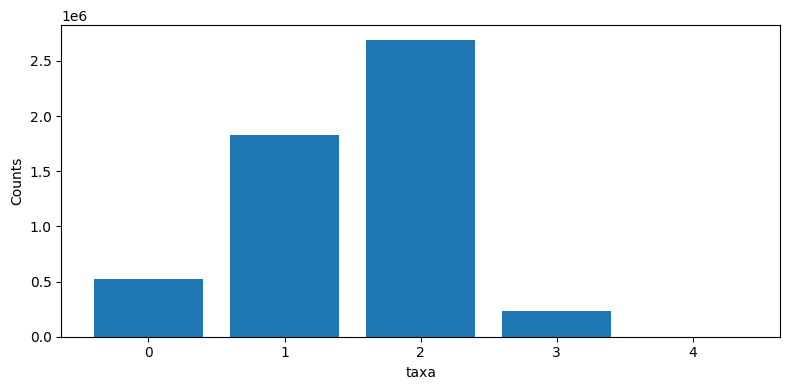

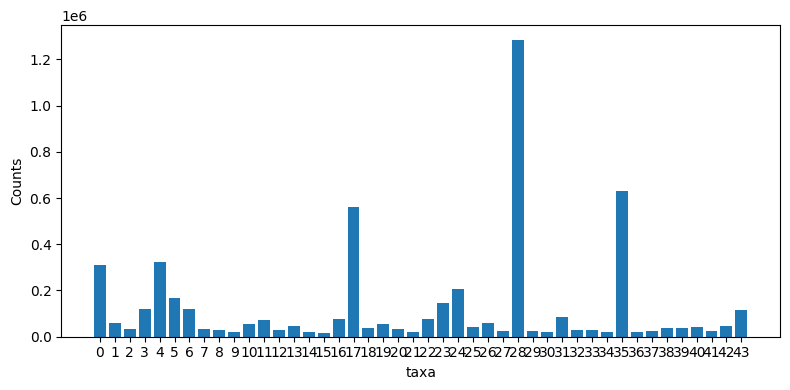

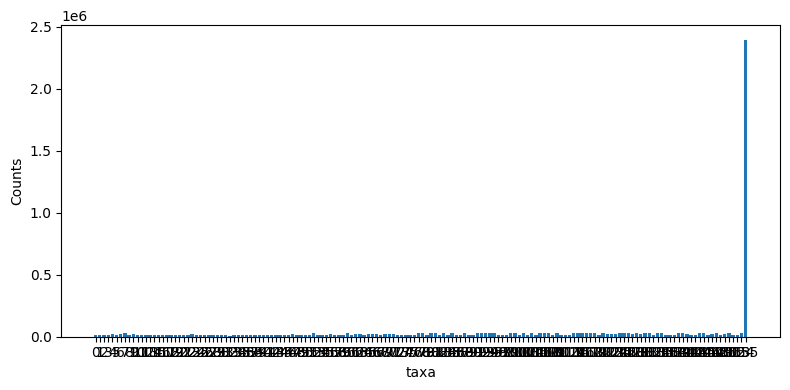

In [10]:
import matplotlib.pyplot as plt

def plot_dict_bar(data: dict):
    counts = {}
    index = 0
    for taxon in sorted(data):
        counts[str(index)] = data[taxon]
        index += 1
    keys = list(counts.keys())
    counts = list(counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(keys, counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(domain_grouping)
plot_dict_bar(phylum_grouping)
plot_dict_bar(genus_grouping)


In [13]:
random.seed(7)


def prepare_datasets(
        mapping: dict,
        n_test: int,
        n_max_training: int,
        validation_fraction: float,
        dst: str
        ) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        mapping: Map an index to a taxonomy.
        n_test: Number of reads for each taxon in the test set.
        validation_fraction: Fraction of non-test data used for validation.
        dst: Save directory.
    """
    taxon_to_read_IDs = {k: [] for k in mapping}
    reversed_mapping = {tuple(v): k for k, v in mapping.items()}
    granularity = len(mapping["0"])
    # Count reads in each taxon.
    i = 0
    for domain in BERTAX_DOMAINS:
        print(f"Inspecting `{domain}`.")
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_ID = None
            for line in tqdm(f):
                if line.startswith(">"):
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    if tax_id in lookup_table:
                        current_taxon = lookup_table[tax_id][:granularity]
                        if current_taxon in reversed_mapping:
                            current_ID = reversed_mapping[current_taxon]
                        else:
                            current_ID = reversed_mapping[("unknown", )]
                elif current_ID:
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[current_ID].append(i)
                        i += 1
    # Split reads into distinct sets.
    train = {k: [] for k in mapping}
    validation = {k: [] for k in mapping}
    test = {k: [] for k in mapping}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:n_test]
        if len(taxon_to_read_IDs[taxon]) > n_max_training:
            train_data = taxon_to_read_IDs[taxon][n_test:n_test + n_max_training]
        else:
            train_data = taxon_to_read_IDs[taxon][n_test:]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    # Generate data.
    for name, data in zip(("test", "train", "validate"), (test, train, validation)):
        print(f"{name} set.")
        elements = set()
        for indices in data.values():
            elements.update(indices)
        N = sum([len(v) for v in data.values()])
        with tqdm(total=N) as progress_bar:
            assert N == len(elements), "Unexpected counts."
            x = np.zeros((N, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
            y = np.zeros(N, dtype=np.uint16)
            i = 0
            local_i = 0
            for domain in BERTAX_DOMAINS:
                # print(f"Inspecting `{domain}`.")
                with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
                    current_ID = None
                    for line in tqdm(f):
                        if line.startswith(">"):
                            tax_id = line.strip()
                            tax_id = tax_id.replace(">", "")
                            tax_id = tax_id.split(" ")[0]
                            if tax_id in lookup_table:
                                current_taxon = lookup_table[tax_id][:granularity]
                                if current_taxon in reversed_mapping:
                                    current_ID = reversed_mapping[current_taxon]
                                else:
                                    current_ID = reversed_mapping[("unknown", )]
                        elif current_ID:
                            sequence = line.strip().upper()
                            characters = set(sequence)
                            if len(characters) == 4:
                                if i in elements:
                                    encoding = format.encode_tetramer(sequence)
                                    x[local_i] = encoding
                                    y[local_i] = int(current_ID)
                                    local_i += 1
                                    elements.remove(i)
                                i += 1
                                progress_bar.update(1)
            assert local_i == N
            mkdir(dst + name)
            np.save(dst + name + "/x.npy", x)
            np.save(dst + name + "/y.npy", y)


with open(BERTAX_STATISTIC_DIRECTORY + "genus_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 100_000, 0.05, BERTAX_GENUS)

Inspecting `Archaea_db.fa`.


1070306it [00:39, 26955.97it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:18, 27516.03it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:08, 28669.24it/s]


Inspecting `Viruses_db.fa`.


507606it [00:16, 30102.51it/s]


test set.


1070306it [00:41, 25682.54it/s]                           
3806366it [02:27, 25870.61it/s]
5415562it [03:52, 23243.38it/s]
507606it [00:17, 28369.69it/s]]
5388074it [07:20, 12235.38it/s]


train set.


1070306it [01:18, 13693.18it/s] [01:18<04:57, 6818.37it/s]
3806366it [07:56, 7990.45it/s]20 [09:14<1:21:47, 25.95it/s] 
5415562it [1:05:24, 1379.83it/s]                               
507606it [00:21, 23516.19it/s]/s]
5388074it [1:15:11, 1194.36it/s] 


validate set.


1070306it [00:47, 22683.73it/s]                           
3806366it [02:26, 25900.03it/s]
5415562it [03:45, 24026.71it/s]
507606it [00:19, 26680.85it/s]]
5388074it [07:19, 12268.94it/s]


In [14]:
with open(BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 2_000_000, 0.05, BERTAX_PHYLUM)

Inspecting `Archaea_db.fa`.


1070306it [00:38, 27746.08it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:11, 28852.29it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:09, 28634.58it/s]


Inspecting `Viruses_db.fa`.


507606it [00:17, 28251.23it/s]


test set.


1070306it [00:39, 26964.38it/s]                         
3806366it [02:22, 26773.29it/s]
5415562it [03:21, 26848.14it/s]
507606it [00:24, 20820.36it/s]]
5388074it [06:48, 13196.87it/s]


train set.


1070306it [02:21, 7584.19it/s]3 [02:21<22:16, 3366.06it/s]
3806366it [08:06, 7830.93it/s]93 [10:27<11:51, 3652.13it/s]
5415562it [11:52, 7599.03it/s]                             
507606it [01:04, 7863.72it/s]]
5388074it [23:40, 3794.00it/s]


validate set.


1070306it [00:45, 23477.21it/s]                           
3806366it [02:32, 24997.29it/s]
5415562it [03:40, 24595.01it/s]
507606it [00:22, 22477.95it/s]]
5388074it [07:21, 12204.70it/s]


In [ ]:
total = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
    print(f"Domain: {domain}. Total: {total}")

x = np.zeros((total, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
i = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    encoding = format.encode_tetramer(sequence)
                    x[i] = encoding
                    i += 1
np.save(PROCESSED_PRETRAINING_DATA + "/x.npy", x)

# 2. Validate Data

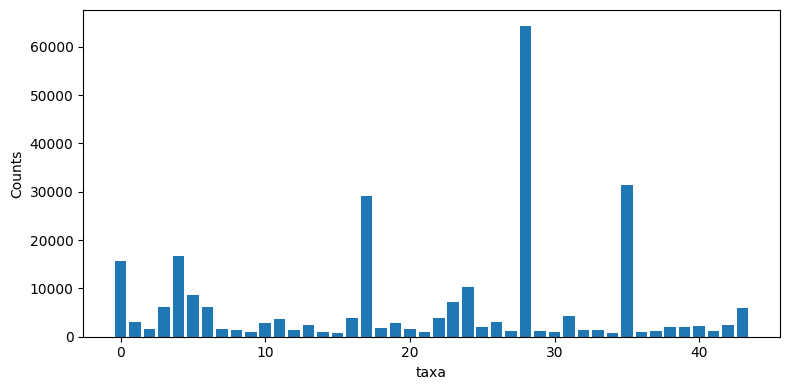

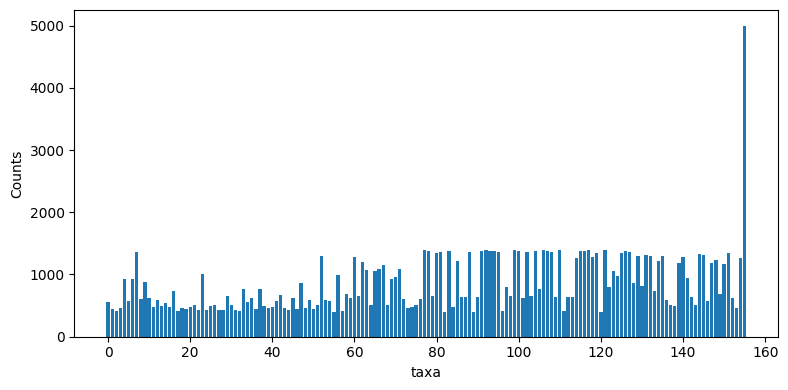

In [9]:
def plot_dict_bar(path: dict):
    y = np.load(path + "validate/y.npy")
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(BERTAX_PHYLUM)
plot_dict_bar(BERTAX_GENUS)

# 3. Train Classification Models

## Prepare Training Benchmark

In [3]:
import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
from torch import nn, exp


def load_data(
        classification_dir: str,
        mapping_filepath: str,
        pretraining_dir: str = None,
        batch_size: int = 128,
        ):
    train_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "train/"),
        batch_size=batch_size,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "validate/"),
        batch_size=batch_size,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "test/"),
        batch_size=batch_size,
        shuffle=True
    )
    with open(mapping_filepath, "r") as f:
        mapping = json.load(f)
    if pretraining_dir:
        pretraining_data = DataLoader(
            models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
            batch_size=batch_size,
            shuffle=True
        )
    else:
        pretraining_data = False
    return train_data, validation_data, test_data, mapping, pretraining_data

In [4]:
def benchmark(
        classifier: models.BaseClassifier,
        name: str,
        train_data,
        validation_data,
        test_data,
        max_epochs: int = 20,
        loss_fn = nn.CrossEntropyLoss(),
        evaluation_interval=5000,
        patience_interval=1000,
        learning_rate: float = 0.001,
        patience: int = 3,
        n_max_steps: int = 100_000,
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=learning_rate)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, validation_losses, f1, p = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=patience,
        loss_function=loss_fn,
        loss_function_type="supervised",
        evaluation_interval=evaluation_interval,
        evaluation_maximum_duration=30.0,
        patience_interval=patience_interval,
        n_max_steps=n_max_steps
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    print(f"Training losses: {losses}")
    print(f"Validation losses: {validation_losses}")
    print(f"F1 scores: {f1}")
    print(f"Precisions: {p}")
    if losses:
        fig, ax = plt.subplots(1, 3, figsize=(14, 4))
        x = np.array(list(range(len(losses))))
        x *= patience_interval
        ax[0].plot(x, losses, label="Training")
        ax[0].plot(x, validation_losses, label="Validation")
        ax[0].set(xlabel='Steps', ylabel='Loss')
        ax[0].set_title("Loss Against Steps")
        ax[0].legend()
        ax[1].set(xlabel='Steps', ylabel="F1")
        ax[1].set_title("F1 Score")
        x = np.array(list(range(len(f1[0]))))
        x *= evaluation_interval
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        ax[2].set(xlabel='Steps', ylabel="Precision")
        ax[2].set_title("Precision")
        r = 0
        for ps in p:
            ax[2].plot(x, ps, label=f'Rank {r}')
            r += 1
        ax[2].legend()
        fig.suptitle(f"Classification Training for {name} ({len(train_data)} Reads).")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"F1: {rounded_result}")
    result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Precision: {rounded_result}")
    matrix = models.confusion_matrix(classifier, test_data, "cuda", mapping)
    plt.matshow(matrix)
    plt.show()
    return classifier

### 3.1. Genus-Level Classification

In [5]:
train_data, validation_data, test_data, mapping, pretraining_data = load_data(
    BERTAX_GENUS,
    BERTAX_STATISTIC_DIRECTORY + "genus_indices.json",
    PRETRAINING_DATA,
    128
)

#### 3.1.1. Random Classifier

 50%|████▉     | 10000/20040 [00:15<00:15, 663.10it/s]


tensor(155)
Training took 15.085 s.
Training losses: None
Validation losses: None
F1 scores: None
Precisions: None
F1: [0.24807, 0.030834, 0.0062469]
Precision: [0.24784, 0.030798, 0.0064267]


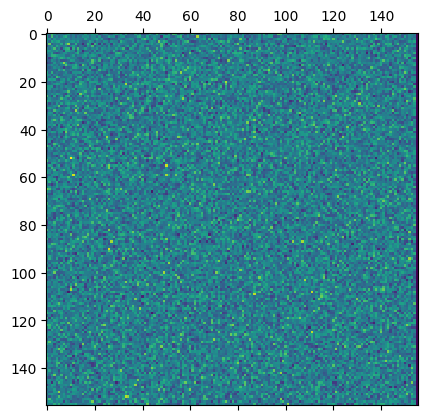

In [12]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
    train_data,
    validation_data,
    test_data
)

#### 3.1.2. CNN (Basic Neural Network)

Number of parameters: 72_172_659


  5%|▌         | 1004/20040 [00:59<4:52:18,  1.09it/s]

Training loss: 6113.95900.  Validation loss: 6372.39984.  Patience: 3


 10%|▉         | 2003/20040 [01:57<6:35:18,  1.32s/it]

Training loss: 5565.81752.  Validation loss: 5823.38448.  Patience: 3


 15%|█▍        | 3004/20040 [02:56<4:39:13,  1.02it/s]

Training loss: 5236.21947.  Validation loss: 5481.35166.  Patience: 3


 20%|█▉        | 4004/20040 [03:55<4:44:20,  1.06s/it]

Training loss: 5011.91400.  Validation loss: 5120.85107.  Patience: 3


 25%|██▍       | 5000/20040 [04:54<11:32, 21.73it/s]  

1/20 F1: [0.61085, 0.49215, 0.24985]. Precision: [0.61683, 0.50867, 0.29284]


 25%|██▍       | 5004/20040 [05:32<17:37:03,  4.22s/it]

Training loss: 4852.95817.  Validation loss: 5106.09645.  Patience: 3


 30%|██▉       | 6006/20040 [06:31<3:43:27,  1.05it/s] 

Training loss: 4729.84567.  Validation loss: 5000.26757.  Patience: 3


 35%|███▍      | 7005/20040 [07:30<3:23:05,  1.07it/s]

Training loss: 4625.55665.  Validation loss: 4777.37153.  Patience: 3


 40%|███▉      | 8004/20040 [08:29<3:05:35,  1.08it/s]

Training loss: 4536.50415.  Validation loss: 4667.96409.  Patience: 3


 45%|████▍     | 9006/20040 [09:28<2:52:59,  1.06it/s]

Training loss: 4456.05016.  Validation loss: 4581.63442.  Patience: 3


 50%|████▉     | 9999/20040 [10:34<07:46, 21.53it/s]  

1/20 F1: [0.68849, 0.61467, 0.35452]. Precision: [0.69253, 0.60243, 0.38629]


 50%|████▉     | 10004/20040 [11:05<10:44:46,  3.85s/it]

Training loss: 4385.00047.  Validation loss: 4558.92920.  Patience: 3


 55%|█████▍    | 11006/20040 [12:04<2:19:08,  1.08it/s] 

Training loss: 4321.19904.  Validation loss: 4469.01801.  Patience: 3


 60%|█████▉    | 12005/20040 [13:03<2:04:22,  1.08it/s]

Training loss: 4265.71125.  Validation loss: 4443.74856.  Patience: 3


 65%|██████▍   | 13004/20040 [14:01<1:48:56,  1.08it/s]

Training loss: 4215.15492.  Validation loss: 4419.80523.  Patience: 3


 70%|██████▉   | 14006/20040 [15:00<1:32:57,  1.08it/s]

Training loss: 4169.76328.  Validation loss: 4289.13175.  Patience: 3


 75%|███████▍  | 14999/20040 [16:04<03:52, 21.70it/s]  

1/20 F1: [0.70749, 0.66619, 0.39377]. Precision: [0.71657, 0.65415, 0.43994]


 75%|███████▍  | 15004/20040 [16:37<5:24:52,  3.87s/it]

Training loss: 4127.25685.  Validation loss: 4313.56913.  Patience: 2


 80%|███████▉  | 16004/20040 [17:36<1:13:42,  1.10s/it]

Training loss: 4088.88209.  Validation loss: 4200.16805.  Patience: 2


 85%|████████▍ | 17004/20040 [18:36<56:12,  1.11s/it]  

Training loss: 4053.10060.  Validation loss: 4227.70385.  Patience: 1


 90%|████████▉ | 18004/20040 [19:37<38:41,  1.14s/it]

Training loss: 4020.48649.  Validation loss: 4121.58920.  Patience: 1


 95%|█████████▍| 19000/20040 [20:37<01:07, 15.36it/s]

Training loss: 3989.25868.  Validation loss: 4157.59902.  Patience: 0
The model is overfitting; stopping early.
Training took 1237.104 s.
Training losses: [6113.959003686905, 5565.817522287369, 5236.21947145462, 5011.913995295763, 4852.958174943924, 4729.845674872398, 4625.556654197829, 4536.50415211916, 4456.050156315167, 4385.00046864152, 4321.19903704795, 4265.711248859763, 4215.154915108131, 4169.7632792166305, 4127.256851828099, 4088.8820900581777, 4053.1006048532095, 4020.486494898796, 3989.258680428329]
Validation losses: [6372.399836464987, 5823.384483784878, 5481.351657796721, 5120.851069915864, 5106.096446508828, 5000.267570344826, 4777.371530090224, 4667.964092500726, 4581.634423642355, 4558.9291951760315, 4469.018012561776, 4443.748561519799, 4419.805225340395, 4289.13175398313, 4313.569132674758, 4200.168050686219, 4227.703852361373, 4121.589202607107, 4157.599016170109]
F1 scores: [array([0.6108498 , 0.68848926, 0.70748679]), array([0.49214804, 0.6146699 , 0.66619345]), a

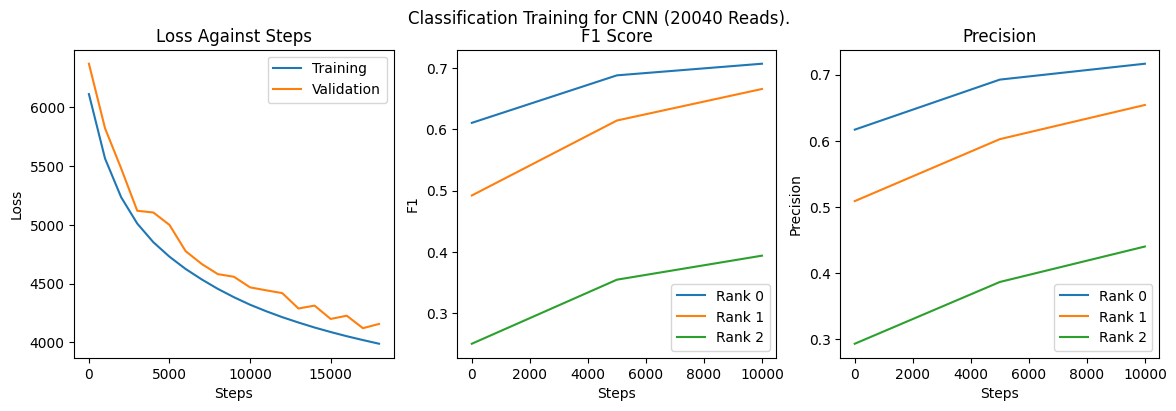

F1: [0.70365, 0.70124, 0.42256]
Precision: [0.70067, 0.71556, 0.47314]


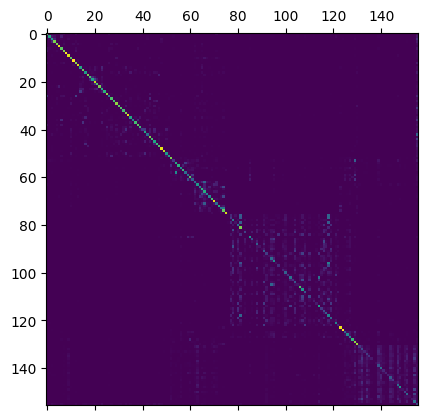

In [7]:
from torch.nn import Module, Conv1d, ReLU, Sequential, Flatten, Linear, Dropout


class CNN(Module):
    def __init__(self, N, M):
        super(CNN, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        self.fc = Sequential(
            Flatten(),
            Dropout(0.1),
            Linear(N * 128, int(N // 4)),
            ReLU(),
            Dropout(0.1),
            Linear(int(N // 4), 256),
            ReLU(),
            Dropout(0.1),
            Linear(256, M)
        )

    def forward(self, x):
        x = self.conv(x.float())
        x = self.fc(x)
        return x.float()


classifier = models.Classifier(
    BERTAX_READ_LENGTH,
    mapping,
    "cuda",
    CNN,
    format.to_channels,
    True
)
trained_classifier = benchmark(
    classifier,
    "CNN",
    train_data,
    validation_data,
    test_data
)

#### 3.1.3. Non-Pretrained Mamba

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of parameters: 786_845


  5%|▍         | 1001/20040 [03:41<32:49:59,  6.21s/it]

Training loss: 1310.39065. Validation loss: 1088.01279. Patience: 3


 10%|▉         | 2001/20040 [07:21<31:07:06,  6.21s/it]

Training loss: 1014.27033. Validation loss: 944.87101. Patience: 3


 15%|█▍        | 3001/20040 [11:17<29:30:47,  6.24s/it]

Training loss: 904.59700. Validation loss: 868.75618. Patience: 3


 20%|█▉        | 4001/20040 [15:20<27:47:57,  6.24s/it]

Training loss: 833.35974. Validation loss: 798.99217. Patience: 3


 25%|██▍       | 5000/20040 [19:09<57:36,  4.35it/s]   

Halting evaluation after 64640 data points.


 25%|██▍       | 5001/20040 [21:27<174:41:53, 41.82s/it]

1/20F1: [0.74474, 0.72807, 0.47064].Precision: [0.74182, 0.71955, 0.51325]
Training loss: 780.50156. Validation loss: 747.85598. Patience: 3


 30%|██▉       | 6001/20040 [25:32<24:18:15,  6.23s/it] 

Training loss: 738.02178. Validation loss: 714.50482. Patience: 3


 35%|███▍      | 7001/20040 [29:34<22:30:13,  6.21s/it]

Training loss: 704.07183. Validation loss: 689.51972. Patience: 3


 40%|███▉      | 8001/20040 [33:29<20:51:05,  6.24s/it]

Training loss: 677.01629. Validation loss: 659.83920. Patience: 3


 45%|████▍     | 9001/20040 [37:16<19:03:05,  6.21s/it]

Training loss: 653.03098. Validation loss: 641.05943. Patience: 3


 50%|████▉     | 10000/20040 [40:58<37:38,  4.44it/s]  

Halting evaluation after 64896 data points.


 50%|████▉     | 10001/20040 [43:14<114:49:41, 41.18s/it]

1/20F1: [0.781, 0.81041, 0.56194].Precision: [0.77955, 0.80971, 0.58865]
Training loss: 632.36458. Validation loss: 620.30006. Patience: 3


 55%|█████▍    | 11001/20040 [47:19<15:40:02,  6.24s/it] 

Training loss: 618.87222. Validation loss: 608.24377. Patience: 3


 60%|█████▉    | 12001/20040 [51:24<13:54:54,  6.23s/it]

Training loss: 602.31275. Validation loss: 605.98942. Patience: 3


 65%|██████▍   | 13001/20040 [55:20<12:09:30,  6.22s/it]

Training loss: 589.94443. Validation loss: 580.76009. Patience: 3


 70%|██████▉   | 14001/20040 [59:57<10:24:32,  6.21s/it]

Training loss: 576.59848. Validation loss: 574.99692. Patience: 3


 75%|███████▍  | 15000/20040 [1:03:25<17:49,  4.71it/s] 

Halting evaluation after 64768 data points.


 75%|███████▍  | 15001/20040 [1:05:45<58:37:55, 41.89s/it]

1/20F1: [0.80072, 0.84297, 0.60797].Precision: [0.81806, 0.83885, 0.63112]
Training loss: 566.92987. Validation loss: 564.09788. Patience: 3


 80%|███████▉  | 16001/20040 [1:09:42<6:58:51,  6.22s/it] 

Training loss: 555.73026. Validation loss: 555.84757. Patience: 3


 85%|████████▍ | 17001/20040 [1:13:41<5:14:34,  6.21s/it]

Training loss: 549.48607. Validation loss: 544.71045. Patience: 3


 90%|████████▉ | 18001/20040 [1:17:46<3:32:03,  6.24s/it]

Training loss: 544.54842. Validation loss: 543.85383. Patience: 3


 95%|█████████▍| 19001/20040 [1:21:53<1:48:02,  6.24s/it]

Training loss: 537.62553. Validation loss: 530.71682. Patience: 3


100%|█████████▉| 20000/20040 [1:25:49<00:09,  4.26it/s]  

Halting evaluation after 63872 data points.


100%|█████████▉| 20001/20040 [1:28:11<27:45, 42.70s/it]

1/20F1: [0.8252, 0.86418, 0.63637].Precision: [0.82782, 0.8615, 0.6607]
Training loss: 528.87850. Validation loss: 520.73687. Patience: 3


  5%|▍         | 961/20040 [03:44<32:58:13,  6.22s/it]

Training loss: 490.66323. Validation loss: 514.00939. Patience: 3


 10%|▉         | 1961/20040 [07:38<31:15:57,  6.23s/it]

Training loss: 507.37890. Validation loss: 513.56553. Patience: 3


 15%|█▍        | 2961/20040 [11:33<29:30:57,  6.22s/it]

Training loss: 504.73813. Validation loss: 505.77062. Patience: 3


 20%|█▉        | 3961/20040 [15:34<27:52:44,  6.24s/it]

Training loss: 501.29727. Validation loss: 509.55769. Patience: 2


 25%|██▍       | 4960/20040 [19:16<1:02:36,  4.01it/s] 

Halting evaluation after 64896 data points.


 25%|██▍       | 4961/20040 [21:35<175:26:00, 41.88s/it]

2/20F1: [0.8306, 0.87298, 0.64666].Precision: [0.83395, 0.87596, 0.68197]
Training loss: 499.17689. Validation loss: 501.95911. Patience: 2


 30%|██▉       | 5961/20040 [25:41<24:24:14,  6.24s/it] 

Training loss: 491.02522. Validation loss: 500.69935. Patience: 2


 35%|███▍      | 6961/20040 [30:18<22:38:11,  6.23s/it]

Training loss: 487.86792. Validation loss: 492.83425. Patience: 2


 40%|███▉      | 7961/20040 [34:16<20:57:41,  6.25s/it]

Training loss: 488.49381. Validation loss: 487.63968. Patience: 2


 45%|████▍     | 8961/20040 [38:11<19:10:49,  6.23s/it]

Training loss: 484.76256. Validation loss: 480.48754. Patience: 2


 50%|████▉     | 9960/20040 [41:53<37:46,  4.45it/s]   

Halting evaluation after 64640 data points.


 50%|████▉     | 9961/20040 [44:13<117:31:44, 41.98s/it]

2/20F1: [0.83721, 0.87649, 0.65869].Precision: [0.83649, 0.88504, 0.68782]
Training loss: 481.72175. Validation loss: 489.08335. Patience: 1


 55%|█████▍    | 10961/20040 [48:17<15:43:19,  6.23s/it]

Training loss: 478.00703. Validation loss: 478.45545. Patience: 1


 60%|█████▉    | 11960/20040 [52:22<35:23,  3.81it/s]   

The model is overfitting; stopping early.
Training took 8442.143 s.
Training losses: [1310.390652000904, 1014.2703296542168, 904.5969960987568, 833.3597373068333, 780.501560524106, 738.0217785984278, 704.0718295276165, 677.0162917524576, 653.0309768468142, 632.3645803928375, 618.8722236603498, 602.3127513080835, 589.9444283545017, 576.5984802693129, 566.9298657774925, 555.7302645742893, 549.4860651567578, 544.548424243927, 537.6255312860012, 528.878499045968, 490.6632259860635, 507.37890297174454, 504.7381343767047, 501.2972692027688, 499.1768949329853, 491.02522118389606, 487.8679151684046, 488.49381490051746, 484.762564457953, 481.7217524573207, 478.00702784210443, 474.36000533401966]
Validation losses: [1088.0127874370041, 944.871007214959, 868.7561796498053, 798.9921728598661, 747.85598412883, 714.5048154210582, 689.5197178553609, 659.8392045591027, 641.0594264511019, 620.3000568742052, 608.2437683610207, 605.9894184482858, 580.7600899322613, 574.9969153960303, 564.097879403228, 55

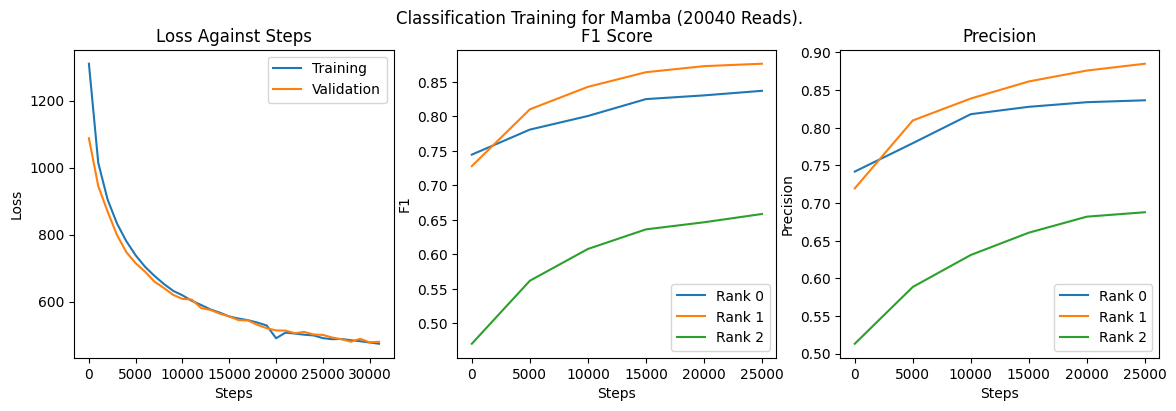

F1: [0.76772, 0.87857, 0.66244]
Precision: [0.76079, 0.88387, 0.70553]


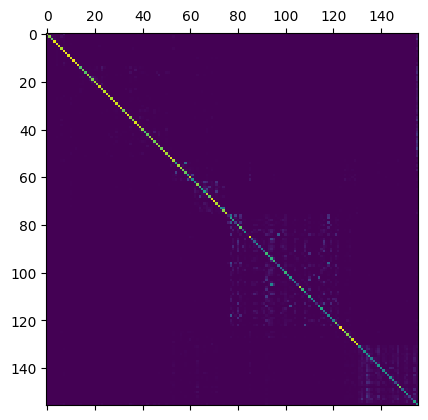

In [6]:
from torch.optim import Adam, AdamW
import torch
from mamba_ssm import Mamba
from torch import nn


class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

    def forward(self, x):
        return x + self.mamba(self.norm(x))


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 6,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        h = self.embedding(x)
        for block in self.layers:
            h = block(h)   # each Mamba block returns [B, L, d_model]
        h = self.norm(h)
        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            logits = self.classifier(pooled)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)
model = benchmark(
    classifier,
    "Mamba",
    train_data,
    validation_data,
    test_data,
    evaluation_interval=5000,
)

#### 3.1.4. Pretrained Mamba

In [ ]:
from torch.optim import Adam, AdamW
import torch
from mamba_ssm import Mamba
from torch import nn


class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

    def forward(self, x):
        return x + self.mamba(self.norm(x))


class MambaSequenceClassifier(nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 6,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        pooling = "mean",
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        h = self.embedding(x)
        for block in self.layers:
            h = block(h)   # each Mamba block returns [B, L, d_model]
        h = self.norm(h)
        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            logits = self.classifier(pooled)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    MambaSequenceClassifier,
    format.to_tetramers,
    True
)
optimizer = AdamW(classifier.get_parameters(), lr=0.001)
print("Pretraining")
classifier.pretrain(
    pretraining_data,
    optimizer,
    max_batches=30_000,
    vocab_size=256,
    patience=3,
    mlm_probability=0.3
)
print("Fine-tuning")
model = benchmark(
    classifier,
    "Mamba",
    train_data,
    validation_data,
    test_data,
    evaluation_interval=5000,
)